In [ ]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("data/", one_hot=False)

import os
import enum
import logging
import shutil, sys                                                                                                                                                    
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from keras import backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator

K.set_image_dim_ordering('th')



Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Using TensorFlow backend.


In [28]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 5000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

# Load the Mnist test data
xTest = mnist.test.images[:n_images]
yTest = list(mnist.test.labels[:n_images])
xTest = xTest.reshape(xTest.shape[0], 1, 28, 28)
# # convert from int to float
xTest = xTest.astype('float32')
xTestBackup = xTest.copy()
yTestBackup = yTest.copy()

xTrain = mnist.train.images[:10000]
yTrain = list(mnist.train.labels[:10000])
xTrain = xTrain.reshape(xTrain.shape[0], 1, 28, 28)
xTrain = xTrain.astype('float32')
xTrainBackup = xTrain.copy()
yTrainBackup = yTrain.copy()

In [29]:
Shade = "Shade"
Rotate = "Rotate"
Sheer = "Sheer"
Shift = "Shift"

Test = "Test"
Train = "Train"

In [30]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out


In [31]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [32]:
def reloadData(dataType):
    if dataType == "Test": # Reset test data
        global xTest
        global yTest
        xTest[:] = xTestBackup
        yTest[:] = yTestBackup
    elif dataType == "Train": # Reset training data
        global xTrain
        global yTrain
        xTrain[:] = xTrainBackup
        yTrain[:] = yTrainBackup
        

In [33]:
def EvaluateModel(xData, yData, shuffle):
    input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': xData}, y= np.array(yData),
            batch_size=batch_size, shuffle=shuffle)
    global model
    accuracy = model.evaluate(input_fn)
    return accuracy

In [34]:
def TrainModel( xTrain, yTrain, shuffle ):
    input_fn = tf.estimator.inputs.numpy_input_fn(
            x={'images': xTrain}, y= np.array(yTrain),
            batch_size=batch_size, shuffle=shuffle)
    global model
    # Train the Model
    model.train(input_fn, steps=num_steps)

In [35]:
def Transform( xData, yData, tType, value ):
    
    n_images = len(xData)
    
    # tType = 1 for shade
    if tType == "Shade":
        Xnew = [[[[v-value if v-value>0.0 else 0.0 for v in n] for n in x[0]]] for x in xData]
        Xnew = np.array(Xnew)
        xData[:] = Xnew.astype('float32')
        return;
        
    # tType = 2 for rotation
    if tType == "Rotate":
        datagen = ImageDataGenerator(rotation_range=value)# fit parameters from data
                
    # tType = 3 for sheer
    if tType == "Sheer":
        datagen = ImageDataGenerator(shear_range=value)# fit parameters from data
        
    # tType = 3 for shift
    if tType == "Shift":   
        datagen = ImageDataGenerator(width_shift_range=value, height_shift_range=value)
        
    datagen.fit(xData)
    # configure batch size and retrieve one batch of images
    for xBatch, yBatch in datagen.flow(xData, yData, batch_size=n_images, shuffle=False):
        xData[:] = xBatch
        yData[:] = yBatch
        break

In [36]:
def TestModel( xTest, yTest ):
    global model
    # Prepare the input data
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x={'images': xTest}, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    
    # Calculate the accuracy of model
    accuracy = EvaluateModel( xTest, yTest )
    return preds, accuracy

In [37]:
def DisplayData( xTest, yTest ):
    for i in range(len(xTest)):
        plt.imshow(np.reshape(xTest[i], [28, 28]), cmap='gray')
        plt.show()
        print ("Image Label: ", yTest[i])

In [38]:
def OpenFile(MT):
    filename = str(MT)+".txt"
    fp = open(filename, 'w')
    return fp

def CloseFile(fp):
    fp.close()
    
logging.getLogger("tensorflow").setLevel(logging.INFO)
#Shade = "Shade"
#Rotate = "Rotate"
#Sheer = "Sheer"
#Shift = "Shift"
def Perform (MT, fp, value, mode):
    
    if ( MT=="Shuffle" ):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        #print ("Training model")
        #TrainModel(xTrain, yTrain, model, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Angle: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
    
    if ( MT=="Rotate" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Transforming training data")
        Transform(xTrain, yTrain, Rotate, value)
        print ("Training model")
        TrainModel(xTrain, yTrain)
        print ("Reloading Test data")
        reloadData(Test)
        print ("Transforming testing Model")
        Transform(xTest, yTest, Rotate, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest)
        print("Angle: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
                
    if ( MT=="Shade" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Reloading Test data")
        reloadData(Test)
        
        if mode == Train or mode == "Both":
            print ("Transforming training data")
            Transform(xTrain, yTrain, Shade, value)
            print ("Training model")
            TrainModel(xTrain, yTrain, False)       
        if mode == Test or mode == "Both":
            print ("Transforming testing Model")
            Transform(xTest, yTest, Shade, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, False)
        print("Shade value: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
    
    if ( MT=="Sheer" ):
        print ("Reloading training data")
        reloadData(Train)
        print ("Transforming training data")
        Transform(xTrain, yTrain, Sheer, value)
        print ("Training model")
        TrainModel(xTrain, yTrain)
        print ("Reloading Test data")
        reloadData(Test)
        print ("Transforming testing Model")
        Transform(xTest, yTest, Sheer, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest)
        print("Sheer value: ", value, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")
        
    if ( MT=="Shift" ):
        value = 0.0
        print ("Reset model")
        model = tf.estimator.Estimator(model_fn)
        print ("Reloading training data")
        reloadData(Train)
        print ("Transforming training data")
        value = n*0.005
        Transform(xTrain, yTrain, Shift, value)
        print ("Training model")
        TrainModel(xTrain, yTrain)
        print ("Reloading Test data")
        reloadData(Test)
        print ("Transforming testing Model")
        Transform(xTest, yTest, Shift, value)
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest)
        print("Shift value: ", value, " Accuracy: ", accuracy)
        if write==1:
            fp.write(str(value)+"\t"+str(accuracy['accuracy'])+"\n")

In [ ]:
fp = OpenFile("Shade_"+str(Train))
model_dir = "models/Shade_"+str(Train)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    Perform(Shade, fp, n*0.005, Train)
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shade_Train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2afbe4777c50>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training data
Reloading Test data
Transforming training data
Training model
Instructions for updating:
To construct input pipelin

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.02  Accuracy:  {'accuracy': 0.8964, 'loss': 0.44470614, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3122752, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.27777526.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-00:43:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Sh

INFO:tensorflow:loss = 2.3342962, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.10434065.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-00:51:30
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-00:51:36
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9056, global_step = 79, loss = 0.36899838
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.055  Accuracy:  {'accuracy': 0.9056, 'loss': 0.36899838, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tenso

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.085  Accuracy:  {'accuracy': 0.9268, 'loss': 0.26201656, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3124084, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.16167766.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:00:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/S

INFO:tensorflow:loss = 2.310012, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.07728524.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:08:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-01:08:25
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9372, global_step = 79, loss = 0.2141413
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.12  Accuracy:  {'accuracy': 0.9372, 'loss': 0.2141413, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflo

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.15  Accuracy:  {'accuracy': 0.9098, 'loss': 0.3389846, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3085523, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.023811089.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:17:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Sh

INFO:tensorflow:loss = 2.2948442, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.040898096.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:24:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-01:24:55
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9176, global_step = 79, loss = 0.3140211
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.185  Accuracy:  {'accuracy': 0.9176, 'loss': 0.3140211, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensor

INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9078, global_step = 79, loss = 0.3859997
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.215  Accuracy:  {'accuracy': 0.9078, 'loss': 0.3859997, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2829854, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.16503501.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-0

INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3093705, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.47411114.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:41:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-01:41:20
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9132, global_step = 79, loss = 0.3578121
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.25  Accuracy:  {'accuracy': 0.9132, 'loss': 0.3578121, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming

INFO:tensorflow:Finished evaluation at 2019-06-21-01:48:57
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9398, global_step = 79, loss = 0.26071304
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.28  Accuracy:  {'accuracy': 0.9398, 'loss': 0.26071304, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3094177, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.06451413.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done cal

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3050187, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.11842376.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-01:57:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-01:57:53
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9256, global_step = 79, loss = 0.3060928
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.315  Accuracy:  {'accuracy': 0.9256, 'loss': 0.

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-02:05:39
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9228, global_step = 79, loss = 0.3553974
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.34500000000000003  Accuracy:  {'accuracy': 0.9228, 'loss': 0.3553974, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2957397, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.3208573.
Evaluating Model
IN

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.2912016, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.33714527.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-02:14:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-02:14:40
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9024, global_step = 79, loss = 0.4064235
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Tr

INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-02:22:15
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9296, global_step = 79, loss = 0.43404025
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.41000000000000003  Accuracy:  {'accuracy': 0.9296, 'loss': 0.43404025, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shade_Train/model.ckpt.
INFO:tensorflow:loss = 2.3041766, step = 1
INFO:tensorflow:Saving checkp

INFO:tensorflow:loss = 2.2990766, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shade_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.10113065.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-02:31:04
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-02:31:10
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9366, global_step = 79, loss = 0.418688
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Train/model.ckpt-79
Shade value:  0.445  Accuracy:  {'accuracy': 0.9366, 'loss': 0.418688, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming training data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflo

[0.8998, 0.9178, 0.8764, 0.9216, 0.9356, 0.895, 0.9168, 0.9378, 0.901, 0.9214, 0.9198, 0.9256, 0.8944, 0.9084, 0.8916, 0.9094, 0.889, 0.9268, 0.9284, 0.9102, 0.9092, 0.9324, 0.9114, 0.9144, 0.846, 0.9128, 0.9424, 0.9246, 0.934, 0.7874, 0.9212, 0.9366, 0.9202, 0.9284, 0.9274, 0.911, 0.9212, 0.9374, 0.9182, 0.9058, 0.9286, 0.9164, 0.9184, 0.8782, 0.9196, 0.9214, 0.9114, 0.921, 0.9064, 0.9156, 0.9174, 0.934, 0.9214, 0.9276, 0.8812, 0.924, 0.9182, 0.8898, 0.9204, 0.8832, 0.8868, 0.8978, 0.9004, 0.9432, 0.8666, 0.913, 0.9216, 0.9244, 0.8458, 0.9076, 0.9016, 0.8364, 0.9156, 0.9346, 0.9064, 0.914, 0.806, 0.922, 0.8886, 0.9232, 0.8722, 0.8912, 0.9246, 0.9246, 0.9032, 0.8768, 0.9114, 0.8676, 0.8918, 0.9324, 0.8934, 0.9224, 0.8236, 0.8796, 0.9148, 0.9164, 0.8936, 0.908, 0.8708, 0.9034]


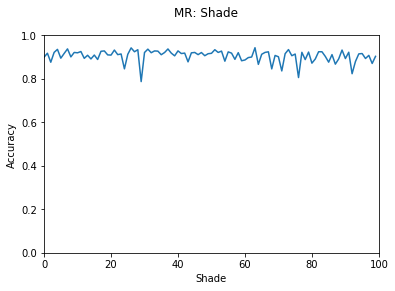

In [14]:
fp = open("Shade_Train.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [15]:
fp = OpenFile("Shade_"+str(Test))
model_dir = "models/Shade_"+str(Test)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
TrainModel(xTrain, yTrain, False)
for n in range(100):
    Perform(Shade, fp, n*0.005, Test)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shade_Test', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2ba3447ecbe0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph w

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-19:50:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-19:50:27
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9016, global_step = 79, loss = 0.49427262
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.045  Accuracy:  {'accuracy': 0.9016, 'loss': 0.49427262, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-19:50:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from mod

Shade value:  0.095  Accuracy:  {'accuracy': 0.9038, 'loss': 0.46278247, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-19:54:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-19:54:13
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9044, global_step = 79, loss = 0.46082196
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.1  Accuracy:  {'accuracy': 0.9044, 'loss': 0.46082196, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Don

INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9052, global_step = 79, loss = 0.42928833
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.15  Accuracy:  {'accuracy': 0.9052, 'loss': 0.42928833, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-19:57:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-19:57:58
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9054, global_step = 79, loss = 0.4249834
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.155  Accuracy

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:01:22
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9078, global_step = 79, loss = 0.39594895
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.20500000000000002  Accuracy:  {'accuracy': 0.9078, 'loss': 0.39594895, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:01:35
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finishe

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:04:59
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:05:06
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9112, global_step = 79, loss = 0.3723436
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.26  Accuracy:  {'accuracy': 0.9112, 'loss': 0.3723436, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:05:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models

Shade value:  0.31  Accuracy:  {'accuracy': 0.9132, 'loss': 0.34540772, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:08:42
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:08:49
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9138, global_step = 79, loss = 0.34161416
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.315  Accuracy:  {'accuracy': 0.9138, 'loss': 0.34161416, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Do

INFO:tensorflow:Finished evaluation at 2019-06-18-20:12:12
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.915, global_step = 79, loss = 0.31846657
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.365  Accuracy:  {'accuracy': 0.915, 'loss': 0.31846657, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:12:25
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:12:32
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9148, global_step = 79, loss = 0.31847715
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: mo

INFO:tensorflow:Starting evaluation at 2019-06-18-20:15:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:15:54
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.9156, global_step = 79, loss = 0.3017446
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.42  Accuracy:  {'accuracy': 0.9156, 'loss': 0.3017446, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:16:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:19:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shade_Test/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-18-20:19:35
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.914, global_step = 79, loss = 0.29350707
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 79: models/Shade_Test/model.ckpt-79
Shade value:  0.47500000000000003  Accuracy:  {'accuracy': 0.914, 'loss': 0.29350707, 'global_step': 79}
Reloading training data
Reloading Test data
Transforming testing Model
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-18-20:19:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring paramet

In [ ]:
fp = open("Shade_Test.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [ ]:
fp = OpenFile("Shade_"+str("Both"))
model_dir = "models/Shade_"+str("Both")
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    Perform(Shade, fp, n*0.005, "Both")
    shutil.rmtree(model_dir)
CloseFile(fp)

In [ ]:
fp = open("Shade_Both.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Shade")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shade")
plt.show()

In [42]:
def ShuffleMT (mode, fp, iteration):
    
    if (mode==Train):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        print ("Training model")
        TrainModel(xTrain, yTrain, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, False)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")
            
    elif (mode==Test):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")
            
    elif (mode=="Both"):
        print ("Reloading training and test data")
        reloadData(Train)
        reloadData(Test)

        print ("Training model")
        TrainModel(xTrain, yTrain, True)
        
        print ("Evaluating Model")
        accuracy = EvaluateModel(xTest, yTest, True)
        print("Iteration: ", iteration, " Accuracy: ", accuracy)
        if (fp):
            fp.write(str(iteration)+"\t"+str(accuracy['accuracy'])+"\n")

In [ ]:
fp = OpenFile("Shuffle_"+str(Train))
model_dir = "models/Shuffle_"+str(Train)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    ShuffleMT(Train, fp, n)
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Train', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2afc563a3898>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Reloading training and test data
Training model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:loss = 2.3021808, step = 1
INFO:tensorflow:Saving checkpoints for 79 into models/Shuffle_Train/model.ckpt.
INFO:tensorflow:Loss for final step: 0.6590098.
Evaluating Model
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-06-21-02:58:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from models/Shuffle_Train/model.ckpt-79
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-06-21-02:58:54
INFO:tensorflow:Saving dict for global step 79: accuracy = 0.8814, global_step = 79, loss = 0.37868664
INFO:tensorflow:Saving 'checkpoint_path

In [ ]:
fp = open("Shuffle_Train.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()

In [ ]:
fp = OpenFile("Shuffle_"+str(Test))
model_dir = "models/Shuffle_"+str(Test)
shutil.rmtree(model_dir)
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
TrainModel(xTrain, yTrain, False)
for n in range(100):
    ShuffleMT(Test, fp, n)
CloseFile(fp)

[0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274, 0.9274]


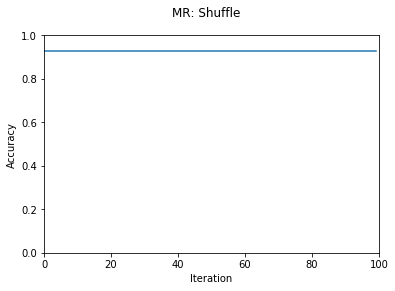

In [39]:
fp = open("Shuffle_Test.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()

In [40]:
fp = OpenFile("Shuffle_"+str("Both"))
model_dir = "models/Shuffle_"+str("Both")
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
for n in range(100):
    ShuffleMT("Both", fp, n)
    shutil.rmtree(model_dir)
CloseFile(fp)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'models/Shuffle_Both', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x2afc563a9668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


NameError: name 'ShuffleMT' is not defined

In [ ]:
fp = open("Shuffle_Both.txt", 'r')
acc = []
for line in fp:
    line = line.strip()
    x = line.split("\t")
    acc.append(float(x[1]))
print(acc)
plt.axis([0, 100, 0, 1])
plt.plot(np.arange(0,100,1),acc)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.suptitle("MR: Shuffle")
plt.show()

In [ ]:
fp = OpenFile("results/Shift_"+str("Test"))
model_dir = "models/Shift_"+str("Test")
model = tf.estimator.Estimator(model_fn, model_dir=model_dir)
TrainModel(xTrain, yTrain, False)

